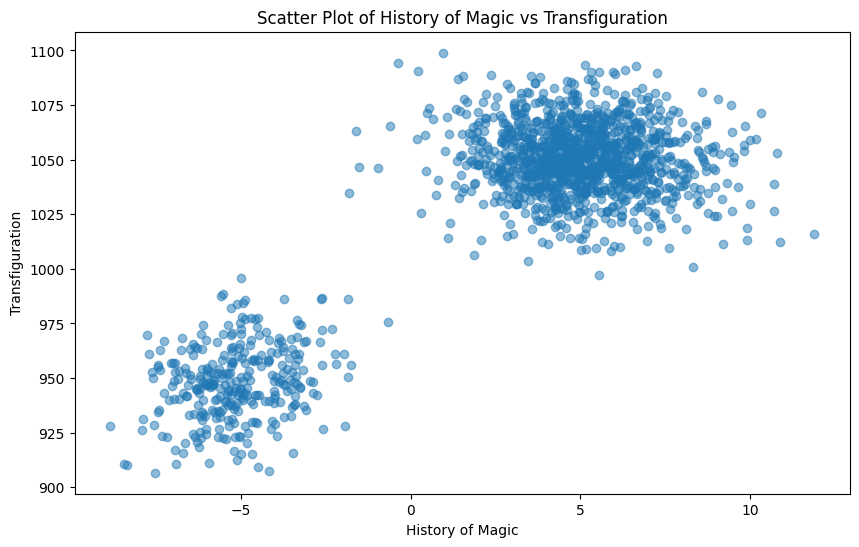

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class dslr:
    def __init__(self, path) -> None:
        self.df = pd.read_csv(path)

    def describe(self) -> pd.DataFrame:        
        df = self.df.select_dtypes(include='number')
        df = df.drop(['Index'], axis=1)
        df = df.dropna(axis=1, how='all')
        results = {}
        
        for column_name, column_data in df.items():
            values = column_data.dropna().values
            sorted_values = np.sort(values)
            count = len(sorted_values)
            mean = np.sum(sorted_values) / count
            std = np.sqrt(np.sum((sorted_values - mean) ** 2) / count)
            min_val = sorted_values[0]
            q25 = np.percentile(sorted_values, 25)
            q50 = np.percentile(sorted_values, 50)
            q75 = np.percentile(sorted_values, 75)
            max_val = sorted_values[-1]
            
            results[column_name] = {
                "Count": count,
                "Mean": mean,
                "Std": std,
                "Min": min_val,
                "25%": q25,
                "50%": q50,
                "75%": q75,
                "Max": max_val
            }
        
        return pd.DataFrame(results)
    
    def histogram(self):
        df = self.df
        houses = df.loc[:, 'Hogwarts House'].unique()
        courses = df.drop(['Index', 'Hogwarts House', 'First Name', 'Last Name', 'Birthday', 'Best Hand'], axis=1)
        courses = courses.dropna()
        
        courses_with_houses = courses.join(self.df['Hogwarts House'])
        
        plt.figure(figsize=(20, 16))  # Adjust figure size based on the number of rows
        
        for i, course in enumerate(courses.columns, 1):
            plt.subplot(5, 3, i)  # Use calculated number of rows and 3 columns
            for house in houses:
                # Select course scores for the current house
                house_scores = courses_with_houses[courses_with_houses['Hogwarts House'] == house][course]
                # Plot histogram for the current course and house
                plt.hist(house_scores, alpha=0.5, bins=15, label=house)
            plt.title(course)
            plt.legend()
        plt.tight_layout()
        plt.show()
        
    def scatter_plot(self):
        # Select numeric features
        numeric_df = self.df.select_dtypes(include='number')
        numeric_df = numeric_df.drop(['Index'], axis=1)  # Assuming 'Index' is not relevant

        # Calculate correlations
        correlations = numeric_df.corr()

        # Find the two features with the highest correlation (excluding self-correlation of 1)
        # Unstack correlation matrix, sort by values, and drop duplicates
        sorted_correlations = correlations.unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates()
        # Filter out self-correlations which have a correlation of 1
        sorted_correlations = sorted_correlations[sorted_correlations < 1]
        # Get the most correlated features
        most_correlated_features = sorted_correlations.index[0]

        # Plot scatter plot of the two most similar features
        plt.figure(figsize=(10, 6))
        plt.scatter(numeric_df[most_correlated_features[0]], numeric_df[most_correlated_features[1]], alpha=0.5)
        plt.title(f'Scatter Plot of {most_correlated_features[0]} vs {most_correlated_features[1]}')
        plt.xlabel(most_correlated_features[0])
        plt.ylabel(most_correlated_features[1])
        plt.show()
    
test = dslr("datasets/dataset_train.csv")
test.scatter_plot()